In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

from flwr_datasets.partitioner import PathologicalPartitioner
partitioner = PathologicalPartitioner(
    num_partitions=NUM_CLIENTS,
    partition_by="label",
    num_classes_per_partition=2,
    class_assignment_mode="random", # ['random', 'deterministic', 'first-deterministic']
    seed=42
)

In [ ]:
def load_datasets(partition_id: int):
    fds=FederatedDataset(dataset="mnist", partitioners={"train": partitioner})
    partition=fds.load_partition(partition_id)

    print(f"Partition {partition_id} size: {len(partition)}")
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    print(f"Partition {partition_id} train size: {len(partition_train_test['train'])}")
    print(f"Partition {partition_id} test size: {len(partition_train_test['test'])}")

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))
        ]
    )
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    train_batch_size = min(BATCH_SIZE, max(2, len(partition_train_test["train"])))

    trainloader = DataLoader(
        partition_train_test["train"],
        batch_size=train_batch_size,
        shuffle=True,
        drop_last=(len(partition_train_test["train"]) % train_batch_size == 1)
    )

    valloader = DataLoader(
        partition_train_test["test"],
        batch_size=BATCH_SIZE,
        drop_last=(len(partition_train_test["test"]) == 1)
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict()
    for k, v in params_dict:
        if v.size == 0:
            print(f"Warning: Parameter {k} is empty!")
            continue
        state_dict[k] = torch.tensor(v)

    net.load_state_dict(state_dict, strict=True)

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    # optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images,labels=batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            if images.size(0)<=1:
                continue
            else:
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data,1)[1]==labels).sum().item()

        if total>0:
            epoch_loss /= total
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
test_accuracies = []
loss_values = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            loss_values.append(loss)
            print(f"Round {server_round}: Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=2710) 2025-05-01 04:42:09.203693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2710) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=2710) E0000 00:00:1746074529.343148    2710 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=2710) E0000 00:00:1746074529.355147    2710 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 169287.62 examples/s]
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Loss: 0.0680, Test Accuracy: 0.2376
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=2710, ip=172.28.0.12, actor_id=79b5a136b71f6076878c573f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fa6d2ea4dd0>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/mnist/paths-info/77f3279092a1c1579b2250db8eafed0ad422088c

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=2710, ip=172.28.0.12, actor_id=79b5a136b71f6076878c573f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fa6d2ea4dd0>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=message, cont

(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 4 results and 1 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
Round 2: Test Loss: 0.0402, Test Accuracy: 0.5053
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Loss: 0.0442, Test Accuracy: 0.5496
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 4: Test Loss: 0.0713, Test Accuracy: 0.3249
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 5: Test Loss: 0.0218, Test Accuracy: 0.7732
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Loss: 0.0200, Test Accuracy: 0.8246
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 7: Test Loss: 0.0333, Test Accuracy: 0.6381
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Loss: 0.0375, Test Accuracy: 0.7159
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Loss: 0.0059, Test Accuracy: 0.9586
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Loss: 0.0268, Test Accuracy: 0.7887
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 11: Test Loss: 0.0174, Test Accuracy: 0.8417
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 12: Test Loss: 0.0344, Test Accuracy: 0.7052
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Loss: 0.0083, Test Accuracy: 0.9202
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 14: Test Loss: 0.0357, Test Accuracy: 0.6586
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 15: Test Loss: 0.0187, Test Accuracy: 0.8210
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Test Loss: 0.0170, Test Accuracy: 0.8286
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Test Loss: 0.0131, Test Accuracy: 0.8744
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Test Loss: 0.0155, Test Accuracy: 0.8384
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Test Loss: 0.0186, Test Accuracy: 0.8002
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Test Loss: 0.0198, Test Accuracy: 0.7768
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Test Loss: 0.0081, Test Accuracy: 0.9229
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Test Loss: 0.0164, Test Accuracy: 0.8216
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 23: Test Loss: 0.0126, Test Accuracy: 0.8619
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Loss: 0.0074, Test Accuracy: 0.9261
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Loss: 0.0117, Test Accuracy: 0.8704
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Loss: 0.0075, Test Accuracy: 0.9228
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 27: Test Loss: 0.0114, Test Accuracy: 0.8779
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 28: Test Loss: 0.0190, Test Accuracy: 0.7822
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
Round 29: Test Loss: 0.0142, Test Accuracy: 0.8332
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Loss: 0.0034, Test Accuracy: 0.9699
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Test Loss: 0.0071, Test Accuracy: 0.9219
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
Round 32: Test Loss: 0.0173, Test Accuracy: 0.8002
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Test Loss: 0.0084, Test Accuracy: 0.9057
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 34: Test Loss: 0.0027, Test Accuracy: 0.9743
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 35: Test Loss: 0.0103, Test Accuracy: 0.8767
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 36: Test Loss: 0.0032, Test Accuracy: 0.9650
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 37: Test Loss: 0.0033, Test Accuracy: 0.9671
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 38: Test Loss: 0.0023, Test Accuracy: 0.9792
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) 
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Test Loss: 0.0055, Test Accuracy: 0.9374
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 40: Test Loss: 0.0056, Test Accuracy: 0.9321
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Test Loss: 0.0053, Test Accuracy: 0.9393
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Test Loss: 0.0031, Test Accuracy: 0.9659
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Test Loss: 0.0097, Test Accuracy: 0.8818
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 44: Test Loss: 0.0079, Test Accuracy: 0.9007
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
Round 45: Test Loss: 0.0057, Test Accuracy: 0.9344
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Test Loss: 0.0061, Test Accuracy: 0.9266
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
Round 47: Test Loss: 0.0064, Test Accuracy: 0.9222
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Test Loss: 0.0043, Test Accuracy: 0.9503
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) 
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Test Loss: 0.0058, Test Accuracy: 0.9307
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14016104052317846489, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 9


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 9 size: 2851
(ClientAppActor pid=2710) Partition 9 train size: 2280
(ClientAppActor pid=2710) Partition 9 test size: 571
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 14661921793316757383, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 3


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 3 size: 3781
(ClientAppActor pid=2710) Partition 3 train size: 3024
(ClientAppActor pid=2710) Partition 3 test size: 757
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 6944546581896379647, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 7


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 7 size: 9807
(ClientAppActor pid=2710) Partition 7 train size: 7845
(ClientAppActor pid=2710) Partition 7 test size: 1962
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1557881760603156878, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 8200137704462427474, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 4


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 4 size: 3017
(ClientAppActor pid=2710) Partition 4 train size: 2413
(ClientAppActor pid=2710) Partition 4 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 1534926649567498861, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 3354470388077482148, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 7600467442218278441, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=2710) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 04:42:55 2025).
(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 13614254852447529531, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 1


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 1 size: 5987
(ClientAppActor pid=2710) Partition 1 train size: 4789
(ClientAppActor pid=2710) Partition 1 test size: 1198
(ClientAppActor pid=2710) Context data: {'run_id': 9867858690948693400, 'node_id': 10684692705047648188, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=2710)   array_records={},
(ClientAppActor pid=2710)   metric_records={},
(ClientAppActor pid=2710)   config_records={}
(ClientAppActor pid=2710) ), 'run_config': {}}
(ClientAppActor pid=2710) Using partition_id: 8


(ClientAppActor pid=2710) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=2710)   warnings.warn(


(ClientAppActor pid=2710) Partition 8 size: 3016
(ClientAppActor pid=2710) Partition 8 train size: 2412
(ClientAppActor pid=2710) Partition 8 test size: 604


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 1998.61s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06801206900559871
INFO :      		round 2: 0.04020397825532396
INFO :      		round 3: 0.044194728695936034
INFO :      		round 4: 0.07128234542384972
INFO :      		round 5: 0.021773695492737232
INFO :      		round 6: 0.019985531728970937
INFO :      		round 7: 0.03333025280451849
INFO :      		round 8: 0.037506482893778954
INFO :      		round 9: 0.00594582757495785
INFO :      		round 10: 0.026845800595720358
INFO :      		round 11: 0.017407464299221003
INFO :      		round 12: 0.03435805447789233
INFO :      		round 13: 0.008339036416973453
INFO :      		round 14: 0.03572717401434342
INFO :      		round 15: 0.018696952667571244
INFO :      		round 16: 0.016980214422907234
INFO :      		round 17: 0.013094259179444609
INFO :      		round 18: 0.01548423062028541
INFO :      		r

Round 50: Test Loss: 0.0022, Test Accuracy: 0.9786


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.2376
Round 2: 0.5053
Round 3: 0.5496
Round 4: 0.3249
Round 5: 0.7732
Round 6: 0.8246
Round 7: 0.6381
Round 8: 0.7159
Round 9: 0.9586
Round 10: 0.7887
Round 11: 0.8417
Round 12: 0.7052
Round 13: 0.9202
Round 14: 0.6586
Round 15: 0.8210
Round 16: 0.8286
Round 17: 0.8744
Round 18: 0.8384
Round 19: 0.8002
Round 20: 0.7768
Round 21: 0.9229
Round 22: 0.8216
Round 23: 0.8619
Round 24: 0.9261
Round 25: 0.8704
Round 26: 0.9228
Round 27: 0.8779
Round 28: 0.7822
Round 29: 0.8332
Round 30: 0.9699
Round 31: 0.9219
Round 32: 0.8002
Round 33: 0.9057
Round 34: 0.9743
Round 35: 0.8767
Round 36: 0.9650
Round 37: 0.9671
Round 38: 0.9792
Round 39: 0.9374
Round 40: 0.9321
Round 41: 0.9393
Round 42: 0.9659
Round 43: 0.8818
Round 44: 0.9007
Round 45: 0.9344
Round 46: 0.9266
Round 47: 0.9222
Round 48: 0.9503
Round 49: 0.9307
Round 50: 0.9786



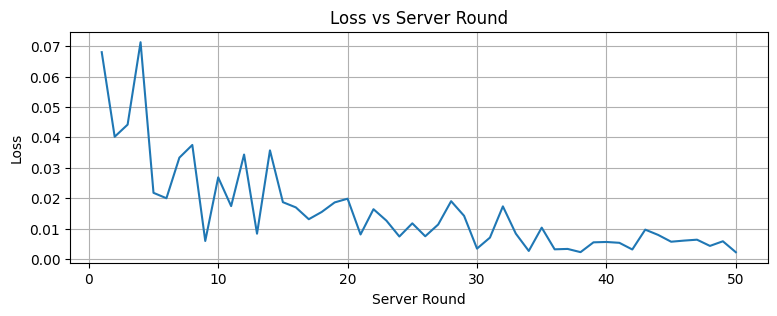

In [ ]:
def plot_loss():
    plt.figure(figsize=(9,3))
    plt.plot(range(1, len(loss_values) + 1), loss_values, linestyle='-')
    plt.title('Loss vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss()

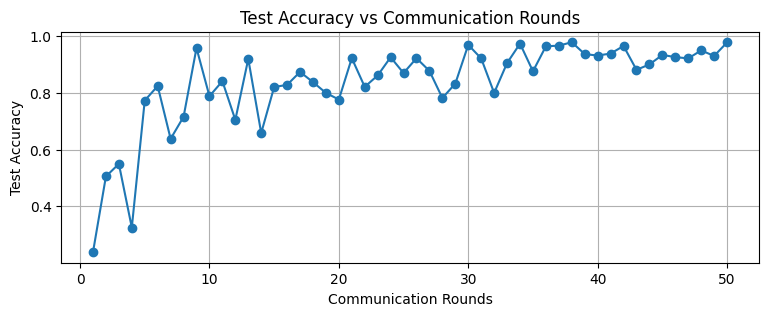

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

In [ ]:
from flwr.server.strategy import FedAvgM # Federated average with momentum

testm_accuracies = []
lossm_values = []

class CustomFedAvgM(FedAvgM):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            testm_accuracies.append(accuracy)
            lossm_values.append(loss)
            print(f"Round {server_round}: Loss: {loss:.4f} Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

strategy = CustomFedAvgM(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    initial_parameters=ndarrays_to_parameters(params),
    server_learning_rate=1.0, #Learning rate
    server_momentum=0.9 #Momentum
)

def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=16993) 2025-05-01 05:15:50.508289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=16993) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=16993) E0000 00:00:1746076550.530077   16993 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=16993) E0000 00:00:1746076550.536213   16993 cuda_blas.cc:1418] Unable to register cuBLAS factor

(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
Round 1: Loss: 0.0658 Test Accuracy: 0.0000
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Loss: 0.1841 Test Accuracy: 0.1700
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) 
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
Round 3: Loss: 0.0486 Test Accuracy: 0.5495
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Loss: 0.0270 Test Accuracy: 0.8095
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) 
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Loss: 0.0189 Test Accuracy: 0.8042
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Loss: 0.0134 Test Accuracy: 0.8510
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Loss: 0.0134 Test Accuracy: 0.8618
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=16993, ip=172.28.0.12, actor_id=11381032f813c4977c41b9b601000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7bc3d992fc10>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/mnist/paths-info/77f3279092a1c1579b2250db8eafed0ad422088c

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=16993, ip=172.28.0.12, actor_id=11381032f813c4977c41b9b601000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7bc3d992fc10>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=message, co

(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
Round 8: Loss: 0.0231 Test Accuracy: 0.7845
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Loss: 0.0105 Test Accuracy: 0.8912
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=16993, ip=172.28.0.12, actor_id=11381032f813c4977c41b9b601000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7bc3d992fc10>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/mnist/paths-info/77f3279092a1c1579b2250db8eafed0ad422088c

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=16993, ip=172.28.0.12, actor_id=11381032f813c4977c41b9b601000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7bc3d992fc10>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=message, co

(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
Round 10: Loss: 0.0109 Test Accuracy: 0.8737
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Loss: 0.0058 Test Accuracy: 0.9379
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Loss: 0.0038 Test Accuracy: 0.9529
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Loss: 0.0105 Test Accuracy: 0.9034
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Loss: 0.0132 Test Accuracy: 0.8678
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Loss: 0.0031 Test Accuracy: 0.9630
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Loss: 0.0021 Test Accuracy: 0.9790
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
Round 17: Loss: 0.0056 Test Accuracy: 0.9331
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Loss: 0.0059 Test Accuracy: 0.9384
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
Round 19: Loss: 0.0030 Test Accuracy: 0.9659
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Loss: 0.0039 Test Accuracy: 0.9605
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=16993, ip=172.28.0.12, actor_id=11381032f813c4977c41b9b601000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7bc3d992fc10>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/ylecun/mnist/paths-info/77f3279092a1c1579b2250db8eafed0ad422088c

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=16993, ip=172.28.0.12, actor_id=11381032f813c4977c41b9b601000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7bc3d992fc10>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=mess

(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Loss: 0.0044 Test Accuracy: 0.9569
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
Round 22: Loss: 0.0043 Test Accuracy: 0.9593
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
Round 23: Loss: 0.0058 Test Accuracy: 0.9415


INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
Round 24: Loss: 0.0023 Test Accuracy: 0.9761
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) 
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Loss: 0.0024 Test Accuracy: 0.9787
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Loss: 0.0018 Test Accuracy: 0.9844
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Loss: 0.0017 Test Accuracy: 0.9844
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Loss: 0.0031 Test Accuracy: 0.9711
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=16993, ip=172.28.0.12, actor_id=11381032f813c4977c41b9b601000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7bc3d992fc10>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/mnist/paths-info/77f3279092a1c1579b2250db8eafed0ad422088c

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=16993, ip=172.28.0.12, actor_id=11381032f813c4977c41b9b601000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7bc3d992fc10>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=message, co

(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604


INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Loss: 0.0043 Test Accuracy: 0.9596
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Loss: 0.0020 Test Accuracy: 0.9813
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Loss: 0.0028 Test Accuracy: 0.9694
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
Round 32: Loss: 0.0103 Test Accuracy: 0.8971
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Loss: 0.0037 Test Accuracy: 0.9640
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Loss: 0.0022 Test Accuracy: 0.9794
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Loss: 0.0026 Test Accuracy: 0.9751
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
Round 36: Loss: 0.0016 Test Accuracy: 0.9811
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Loss: 0.0037 Test Accuracy: 0.9622
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Loss: 0.0019 Test Accuracy: 0.9811
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=16993, ip=172.28.0.12, actor_id=11381032f813c4977c41b9b601000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7bc3d992fc10>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/ylecun/mnist/paths-info/77f3279092a1c1579b2250db8eafed0ad422088c

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=16993, ip=172.28.0.12, actor_id=11381032f813c4977c41b9b601000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7bc3d992fc10>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=mess

(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Loss: 0.0020 Test Accuracy: 0.9817
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Loss: 0.0022 Test Accuracy: 0.9784
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Loss: 0.0017 Test Accuracy: 0.9868
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Loss: 0.0027 Test Accuracy: 0.9683
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Loss: 0.0022 Test Accuracy: 0.9748
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Loss: 0.0011 Test Accuracy: 0.9904
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
Round 45: Loss: 0.0008 Test Accuracy: 0.9927
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Loss: 0.0010 Test Accuracy: 0.9897
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 47: Loss: 0.0021 Test Accuracy: 0.9790
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
Round 48: Loss: 0.0023 Test Accuracy: 0.9775
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Loss: 0.0013 Test Accuracy: 0.9896
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 8377282176883473121, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4518701202422790385, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 7489744964406672639, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) Using the latest cached version of the dataset since mnist couldn't be found on the Hugging Face Hub
(ClientAppActor pid=16993) Found the latest cached dataset configuration 'mnist' at /root/.cache/huggingface/datasets/mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Thu May  1 05:16:13 2025).
(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 9092738609550702029, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17737564392820839358, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 13595789759047477575, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 5


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 5 size: 2851
(ClientAppActor pid=16993) Partition 5 train size: 2280
(ClientAppActor pid=16993) Partition 5 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 4537273483060537098, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 8


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 8 size: 3016
(ClientAppActor pid=16993) Partition 8 train size: 2412
(ClientAppActor pid=16993) Partition 8 test size: 604
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 1368288413220513039, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 9


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 9 size: 2851
(ClientAppActor pid=16993) Partition 9 train size: 2280
(ClientAppActor pid=16993) Partition 9 test size: 571
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 6953556900482089117, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 7


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 7 size: 9807
(ClientAppActor pid=16993) Partition 7 train size: 7845
(ClientAppActor pid=16993) Partition 7 test size: 1962
(ClientAppActor pid=16993) Context data: {'run_id': 16542716492244489339, 'node_id': 17139724252258809771, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=16993)   array_records={},
(ClientAppActor pid=16993)   metric_records={},
(ClientAppActor pid=16993)   config_records={}
(ClientAppActor pid=16993) ), 'run_config': {}}
(ClientAppActor pid=16993) Using partition_id: 1


(ClientAppActor pid=16993) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=16993)   warnings.warn(


(ClientAppActor pid=16993) Partition 1 size: 5987
(ClientAppActor pid=16993) Partition 1 train size: 4789
(ClientAppActor pid=16993) Partition 1 test size: 1198


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 1897.29s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06584417328564143
INFO :      		round 2: 0.18414423192469914
INFO :      		round 3: 0.04858793406241933
INFO :      		round 4: 0.026983186361837132
INFO :      		round 5: 0.01886936485962402
INFO :      		round 6: 0.013398143440362512
INFO :      		round 7: 0.013429584720122232
INFO :      		round 8: 0.0231053982460304
INFO :      		round 9: 0.010500944736605905
INFO :      		round 10: 0.010923128541600761
INFO :      		round 11: 0.005806208048075674
INFO :      		round 12: 0.0037513524733219037
INFO :      		round 13: 0.010463475448902651
INFO :      		round 14: 0.013198695418952152
INFO :      		round 15: 0.003063570648120088
INFO :      		round 16: 0.002127929413042278
INFO :      		round 17: 0.005568242595001163
INFO :      		round 18: 0.0058792221065301796
INFO :     

Round 50: Loss: 0.0012 Test Accuracy: 0.9906


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(testm_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.0000
Round 2: 0.1700
Round 3: 0.5495
Round 4: 0.8095
Round 5: 0.8042
Round 6: 0.8510
Round 7: 0.8618
Round 8: 0.7845
Round 9: 0.8912
Round 10: 0.8737
Round 11: 0.9379
Round 12: 0.9529
Round 13: 0.9034
Round 14: 0.8678
Round 15: 0.9630
Round 16: 0.9790
Round 17: 0.9331
Round 18: 0.9384
Round 19: 0.9659
Round 20: 0.9605
Round 21: 0.9569
Round 22: 0.9593
Round 23: 0.9415
Round 24: 0.9761
Round 25: 0.9787
Round 26: 0.9844
Round 27: 0.9844
Round 28: 0.9711
Round 29: 0.9596
Round 30: 0.9813
Round 31: 0.9694
Round 32: 0.8971
Round 33: 0.9640
Round 34: 0.9794
Round 35: 0.9751
Round 36: 0.9811
Round 37: 0.9622
Round 38: 0.9811
Round 39: 0.9817
Round 40: 0.9784
Round 41: 0.9868
Round 42: 0.9683
Round 43: 0.9748
Round 44: 0.9904
Round 45: 0.9927
Round 46: 0.9897
Round 47: 0.9790
Round 48: 0.9775
Round 49: 0.9896
Round 50: 0.9906



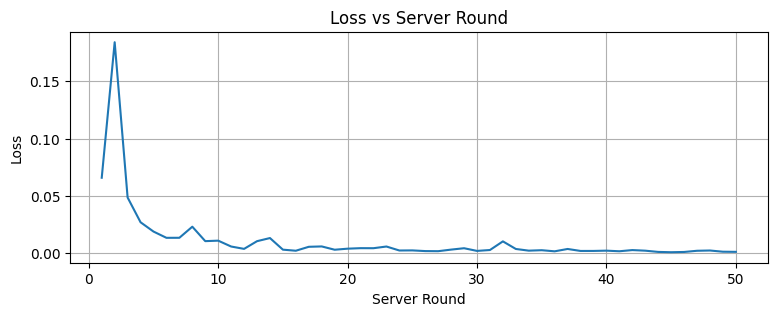

In [ ]:
def plot_loss():
    plt.figure(figsize=(9,3))
    plt.plot(range(1, len(lossm_values) + 1), lossm_values, linestyle='-')
    plt.title('Loss vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss()

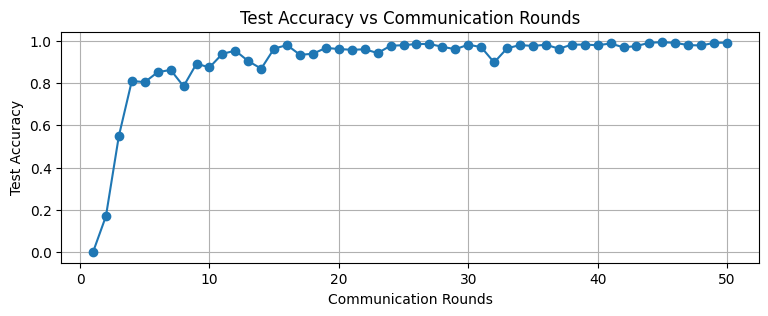

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(testm_accuracies) + 1), testm_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

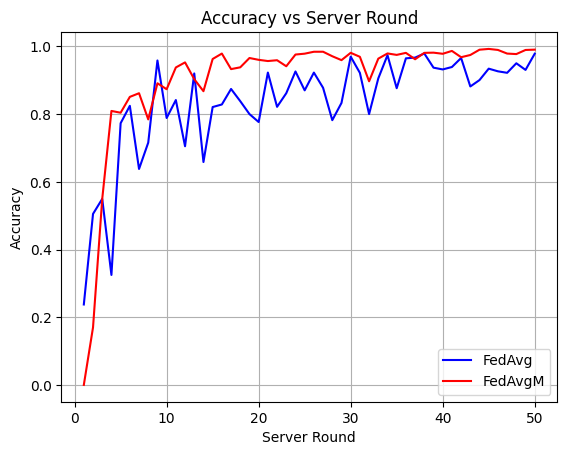

In [ ]:
def plot_accuracies():
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='FedAvg', color='blue', linestyle='-')
    plt.plot(range(1, len(testm_accuracies) + 1), testm_accuracies, label='FedAvgM', color='red', linestyle='-')
    plt.title('Accuracy vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies()

In [ ]:
def train(net,trainloader,epochs:int,global_params=None,mu:float=0.0,verbose=False): # adding proximal term coefficient (mu)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    # optimizer = torch.optim.Adam(net.parameters())
    net.train()

    for epoch in range(epochs):
        correct,total,epoch_loss=0,0,0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs=net(images)
            ce_loss=criterion(outputs,labels)

            # If global model parameters are given and mu is non-zero, apply FedProx algorithm
            if global_params is not None and mu>0:
                prox_term=0.0
                for param,global_param in zip(net.parameters(),global_params):
                    prox_term+=((param-global_param.to(DEVICE))**2).sum()
                ce_loss+=(mu/2)*prox_term # Adding the proximal penalty to the cross-entropy loss

            ce_loss.backward()
            optimizer.step()
            epoch_loss+=ce_loss.item()
            total+=labels.size(0)
            correct+=(outputs.argmax(dim=1)==labels).sum().item()

        if verbose:
            print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Accuracy = {correct / total:.4f}")

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net=net
        self.trainloader=trainloader
        self.valloader=valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net,parameters)
        mu=float(config.get("mu",0.0))
        global_params=[torch.tensor(p,dtype=torch.float32).to(DEVICE) for p in parameters]
        train(self.net,self.trainloader,epochs=1,global_params=global_params,mu=mu)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
from flwr.server.strategy import FedProx

fedprox_accuracies = []
lossp_values = []

class CustomFedProx(FedProx):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result = super().aggregate_evaluate(server_round, results, failures)

        if aggregated_result is not None:
            loss, metrics = aggregated_result
            accuracy = metrics.get("accuracy", 0.0)
            fedprox_accuracies.append(accuracy)
            lossp_values.append(loss)
            print(f"Round {server_round}: Loss: {loss:.4f} Test Accuracy: {accuracy:.4f}")

        return aggregated_result

In [ ]:
strategy_fedprox = CustomFedProx(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    proximal_mu=0.01
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy_fedprox, config=config)

server = ServerApp(server_fn=server_fn)

backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=30526) 2025-05-01 05:47:30.197925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=30526) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=30526) E0000 00:00:1746078450.234153   30526 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=30526) E0000 00:00:1746078450.241187   30526 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter i

(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3128694920536616801, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 11043568266509444605, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 5


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 5 size: 2851
(ClientAppActor pid=30526) Partition 5 train size: 2280
(ClientAppActor pid=30526) Partition 5 test size: 571
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 14807711980736469237, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 7


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 7 size: 9807
(ClientAppActor pid=30526) Partition 7 train size: 7845
(ClientAppActor pid=30526) Partition 7 test size: 1962
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3128694920536616801, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 4844125442459381801, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3297454725870424892, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 2


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 2 size: 3947
(ClientAppActor pid=30526) Partition 2 train size: 3157
(ClientAppActor pid=30526) Partition 2 test size: 790
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 10815769055017880343, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 3


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 3 size: 3781
(ClientAppActor pid=30526) Partition 3 train size: 3024
(ClientAppActor pid=30526) Partition 3 test size: 757
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 10555492960842652489, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 9


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 9 size: 2851
(ClientAppActor pid=30526) Partition 9 train size: 2280
(ClientAppActor pid=30526) Partition 9 test size: 571
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3881990624766279814, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 4


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 4 size: 3017
(ClientAppActor pid=30526) Partition 4 train size: 2413
(ClientAppActor pid=30526) Partition 4 test size: 604
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 11649131759361184147, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 7


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 7 size: 9807
(ClientAppActor pid=30526) Partition 7 train size: 7845
(ClientAppActor pid=30526) Partition 7 test size: 1962
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 9036687926763277901, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 11043568266509444605, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 5


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 5 size: 2851
(ClientAppActor pid=30526) Partition 5 train size: 2280
(ClientAppActor pid=30526) Partition 5 test size: 571
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3128694920536616801, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 4844125442459381801, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3297454725870424892, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 2


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 2 size: 3947
(ClientAppActor pid=30526) Partition 2 train size: 3157
(ClientAppActor pid=30526) Partition 2 test size: 790
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 11649131759361184147, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 7


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 7 size: 9807
(ClientAppActor pid=30526) Partition 7 train size: 7845
(ClientAppActor pid=30526) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Loss: 0.0594 Test Accuracy: 0.3170
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3881990624766279814, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 4


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 4 size: 3017
(ClientAppActor pid=30526) Partition 4 train size: 2413
(ClientAppActor pid=30526) Partition 4 test size: 604
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 11043568266509444605, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 5


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 5 size: 2851
(ClientAppActor pid=30526) Partition 5 train size: 2280
(ClientAppActor pid=30526) Partition 5 test size: 571
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3128694920536616801, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 9036687926763277901, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3297454725870424892, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 2


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 2 size: 3947
(ClientAppActor pid=30526) Partition 2 train size: 3157
(ClientAppActor pid=30526) Partition 2 test size: 790
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 10815769055017880343, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 3


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 3 size: 3781
(ClientAppActor pid=30526) Partition 3 train size: 3024
(ClientAppActor pid=30526) Partition 3 test size: 757
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 14807711980736469237, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 7


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 7 size: 9807
(ClientAppActor pid=30526) Partition 7 train size: 7845
(ClientAppActor pid=30526) Partition 7 test size: 1962
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 10555492960842652489, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 9


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 9 size: 2851
(ClientAppActor pid=30526) Partition 9 train size: 2280
(ClientAppActor pid=30526) Partition 9 test size: 571
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 11649131759361184147, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 7


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 7 size: 9807
(ClientAppActor pid=30526) Partition 7 train size: 7845
(ClientAppActor pid=30526) Partition 7 test size: 1962
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 4844125442459381801, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3881990624766279814, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 4


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 4 size: 3017
(ClientAppActor pid=30526) Partition 4 train size: 2413
(ClientAppActor pid=30526) Partition 4 test size: 604
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 11043568266509444605, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 5


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 5 size: 2851
(ClientAppActor pid=30526) Partition 5 train size: 2280
(ClientAppActor pid=30526) Partition 5 test size: 571
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 10555492960842652489, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 9


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 9 size: 2851
(ClientAppActor pid=30526) Partition 9 train size: 2280
(ClientAppActor pid=30526) Partition 9 test size: 571
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3128694920536616801, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 11649131759361184147, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 7


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 7 size: 9807
(ClientAppActor pid=30526) Partition 7 train size: 7845
(ClientAppActor pid=30526) Partition 7 test size: 1962


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Loss: 0.0584 Test Accuracy: 0.5077
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3881990624766279814, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 4


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 4 size: 3017
(ClientAppActor pid=30526) Partition 4 train size: 2413
(ClientAppActor pid=30526) Partition 4 test size: 604
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 10555492960842652489, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 9


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 9 size: 2851
(ClientAppActor pid=30526) Partition 9 train size: 2280
(ClientAppActor pid=30526) Partition 9 test size: 571
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3128694920536616801, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 9036687926763277901, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 3297454725870424892, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 2


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 2 size: 3947
(ClientAppActor pid=30526) Partition 2 train size: 3157
(ClientAppActor pid=30526) Partition 2 test size: 790
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 11649131759361184147, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 7


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 7 size: 9807
(ClientAppActor pid=30526) Partition 7 train size: 7845
(ClientAppActor pid=30526) Partition 7 test size: 1962
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 4844125442459381801, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 1


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 1 size: 5987
(ClientAppActor pid=30526) Partition 1 train size: 4789
(ClientAppActor pid=30526) Partition 1 test size: 1198
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 14807711980736469237, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 7


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 7 size: 9807
(ClientAppActor pid=30526) Partition 7 train size: 7845
(ClientAppActor pid=30526) Partition 7 test size: 1962
(ClientAppActor pid=30526) Context data: {'run_id': 13438646223575385181, 'node_id': 10815769055017880343, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=30526)   array_records={},
(ClientAppActor pid=30526)   metric_records={},
(ClientAppActor pid=30526)   config_records={}
(ClientAppActor pid=30526) ), 'run_config': {}}
(ClientAppActor pid=30526) Using partition_id: 3


(ClientAppActor pid=30526) /usr/local/lib/python3.11/dist-packages/flwr_datasets/partitioner/pathological_partitioner.py:188: UserWarning: Classes: [2, 8, 9] will NOT be used due to the chosen configuration. If it is undesired behavior consider setting 'first_class_deterministic_assignment=True' which in case when the number of classes is smaller than the number of partitions will utilize all the classes for the created partitions.
(ClientAppActor pid=30526)   warnings.warn(


(ClientAppActor pid=30526) Partition 3 size: 3781
(ClientAppActor pid=30526) Partition 3 train size: 3024
(ClientAppActor pid=30526) Partition 3 test size: 757


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(fedprox_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")

In [ ]:
def plot_loss():
    plt.figure(figsize=(9,3))
    plt.plot(range(1, len(lossp_values) + 1), lossp_values, linestyle='-')
    plt.title('Loss vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss()

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(fedprox_accuracies) + 1), fedprox_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

In [ ]:
def plot_accuracies():
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='FedAvg', color='blue', linestyle='-')
    plt.plot(range(1, len(testm_accuracies) + 1), testm_accuracies, label='FedAvgM', color='red', linestyle='-')
    plt.plot(range(1, len(fedprox_accuracies) + 1), fedprox_accuracies, label='FedProx', color='green', linestyle='-')

    plt.title('Accuracy vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies()